# Github README Demo

In [1]:
import requests
import pandas as pd

data_path = "./dataset/processed_with_log_delta_n.csv"
raw_data = pd.read_csv(data_path)

# def query2IUPAC(text):
#   try:
#     '''This function queries the one given molecule name and returns a SMILES string from the record'''
#     #query the PubChem database
#     r = requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/' + text + '/property/IUPACName/JSON')
#     data = r.json()
#     smi = data["PropertyTable"]["Properties"][0]["IUPACName"]
#     return smi
#   except:
#     return None

# # raw_data["IUPAC"] = raw_data["SMILES"].map(lambda sml: query2IUPAC(sml))
# raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
# raw_data = raw_data.dropna()
# raw_data[50:65]

### README example

In [4]:
import bolift
import PromptTemplate
from dotenv import load_dotenv
load_dotenv()

asktell = bolift.AskTellFewShotTopk(
    model="gpt-3.5-turbo-instruct")

# asktell.tell("3-chloroaniline", -1.37)
# asktell.tell("nitromethane", 0.26)
# asktell.tell("1-bromobutane", -2.43)
# asktell.tell("3-chlorophenol", -0.7)

# yhat = asktell.predict("penta-1,4-diene	")
# print(yhat.mean(), yhat.std())

# pool_list = [
#   "1,5-dimethylnaphthalene",
#   "2-aminophenol",
#   "1hexa-1,5-diene",
#   "1,1,2,3,4,4-hexachlorobuta-1,3-diene"
# ]
# pool=bolift.Pool(pool_list)
# print(asktell.ask(pool))

# asktell.tell("phenol", -0.5)
# yhat = asktell.predict("penta-1,4-diene",)
# print(yhat.mean(), yhat.std())

/Users/shane/opt/anaconda3/envs/lift_clean/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'PromptTemplate'

In [2]:
# data_path = "/Users/shane/repos/BO-LIFT/paper/dataset/processed_with_log_delta_n.csv"
# raw_data = pd.read_csv(data_path, sep=",")
# raw_data = raw_data[:1005].sample(frac=1).reset_index(drop=True)
# x_name = "prompt"
# y_name = "completion"
# N=len(raw_data)

In [3]:
dataset="alloy"
# dataset="biasfree_ocm"

kwargs = dict(
    # prefix="You are a bot who knows chemistry and catalysts. " \
    #         "Below, you'll see examples of experimental procedures to synthesize catalysts and the measured C2 yield in a oxidative methane coupling reaction. " \
    #         "The following question should be answered with a number and finished with ###\n",
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"the corresponding experimental procedure: {x}",
    y_name="the log(charge transfer) [coulombs/cm²]", # inverse prompt : If {y_name} is {y}, then {x_name} is @@@\n{x}###"
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7,
    use_logprobs=False,
    model="gpt-3.5-turbo-instruct"
)
system_message_path = "./prompts/prompt_1.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()


# path = f"./out/calibration/isotonic_{dataset}_{kwargs['model']}_number_of_samples{N}_logrpobs{kwargs['use_logprobs']}.pkl"

# plot_path = f"./out/calibration/isotonic_{dataset}_{kwargs['model']}_number_of_samples{N}_logrpobs{kwargs['use_logprobs']}.png"
asktell=bolift.AskTellFewShotTopk(**kwargs)

# Regression experiments

In [2]:
import bolift
from bolift.llm_model import GaussDist, DiscreteDist
import numpy as np
import json
import pandas as pd
from langchain.prompts.prompt import PromptTemplate
import itertools
import os
import openai
import glob

from dotenv import load_dotenv
load_dotenv()

np.random.seed(0)

/Users/shane/opt/anaconda3/envs/lift_clean/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
len(raw_data)

8783

## Utils

In [5]:
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
# @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_ablation_experiment(asktell, train_data, test_data, system_message="", model=""):
    if isinstance(asktell, bolift.AskTellGPR) or isinstance(asktell, bolift.AskTellFinetuning):
        i=-1 #Hack to pass the case we have len(train_data) == 1
        for i in range(len(train_data)-1):
            asktell.tell(train_data["prompt"].iloc[i], float(train_data["completion"].iloc[i]), train=False)
        asktell.tell(train_data["prompt"].iloc[i+1], float(train_data["completion"].iloc[i+1]), train=True)
    else:
        for i in range(len(train_data)):
            asktell.tell(train_data["prompt"].iloc[i], float(train_data["completion"].iloc[i]))
    x    = []
    y    = []
    yhat = []
    for j in range(len(test_data)):
        x.append(test_data["prompt"].iloc[j])
        y.append(float(test_data["completion"].iloc[j]))
        if model in ["knn",'krr',"gpr"]:
            yhat.append(asktell.predict(test_data["prompt"].iloc[j]))
        else:
            yhat.append(asktell.predict(test_data["prompt"].iloc[j],system_message=system_message))#, system_message=system_message))

    x_filter = [xi for xi, yhi in zip(x, yhat)]# if len(yhi.values) > 0]
    y_filter = [yi for yi, yhi in zip(y, yhat)]# if len(yhi.values) > 0]
    yhat_filter = [yhi for yi, yhi in zip(y, yhat)]# if len(yhi.values) > 0]
    return x_filter, y_filter, yhat_filter

def save_csv(filename, x, y, yhat, data, model, T, k, N, model_class, tokens):
    if not os.path.exists(filename):
        f = open(filename, "w")
        f.write("y;yhat;yprobs;data;model;Temperature;k_selected;N_train;model_class;n_tokens;x\n")
    else:
        f = open(filename, "a")
    for xi, yi, yhi in zip(x, y, yhat):
        if isinstance(yhi, DiscreteDist):
            if len(yhi.values) > 0:
                for v,p in zip(yhi.values, yhi.probs):
                    f.write(f"{yi};{v};{p:.4f};{data};{model};{T};{k};{N};{model_class};{tokens};{xi}\n")
        if isinstance(yhi, GaussDist):
            f.write(f"{yi};{yhi.mean()};{yhi.std():.4f};{data};{model};{T};{k};{N};{model_class};{tokens};{xi}\n")
    f.close()


In [6]:
def get_dataset(data: str, N: int, split=0.8):
    match data:
        case "in-house":
            data_path = "./dataset/data/71023_BO_ready_pool.csv"
            raw_data = pd.read_csv(data_path)
            raw_data['Catalyst'] = raw_data['Prompt'].str.extract(r'(\b[A-Z][a-z]?:[A-Z][a-z]?:[A-Z][a-z]?\b)')
            unique_cat = raw_data['Catalyst'].unique()
            c = {c: 0.2+m*(5/len(unique_cat)) for m, c in enumerate(unique_cat)}
            raw_data['dummy_Completion'] = raw_data['Catalyst'].apply(lambda x: np.random.normal(c[x], 0.05))

            x_name = "Prompt"
            y_name = "dummy_Completion"
        case "ocm":
            data_path = "./dataset/data/12708_ocm_dataset.csv"
            raw_data = pd.read_csv(data_path, sep=";")
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            x_name = "prompt"
            y_name = "completion"
        case "alloy":
            data_path = "./dataset/processed_with_log_delta_n.csv"
            raw_data = pd.read_csv(data_path, sep=",")
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            x_name = "prompt"
            y_name = "completion"
        case "biasfree_ocm":
            data_path = "./dataset/data/bias_free_ocmdataset_p_comp.csv"
            raw_data = pd.read_csv(data_path, sep=",")
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            x_name = "prompt"
            y_name = "completion"
        case "sol":
            data_path = "./dataset/data/esol_iupac.csv"
            raw_data = pd.read_csv(data_path)
            raw_data = raw_data.dropna()
            raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
            x_name = "IUPAC"
            y_name = "measured log(solubility:mol/L)"
        case _:
            raise ValueError("Unknown data")
        
    n_data = raw_data.shape[0]
    indexes = np.random.choice(n_data, int(n_data), replace=False)
    train = np.random.choice(n_data, int(n_data * split), replace=False)
    test = np.setdiff1d(np.arange(n_data), train)
    test = np.random.choice(test, min(200, len(test)), replace=False) # limiting too large test set to avoid expense with OpenAI requests

    if N > len(train):
        raise ValueError(f"N must be less than the training set size. Trainin set size: {len(train)}")
    train_data = raw_data.iloc[train, :].reset_index(drop=True)[:N]
    test_data = raw_data.iloc[test, :].reset_index(drop=True)
    # print(f"Dataset size:  \t{n_data}")
    # print(f"Training size: \t{len(train_data)}")
    # print(f"Test size:     \t{len(test_data)}")

    return raw_data, train_data, test_data, indexes, x_name, y_name


In [7]:
def get_asktell(model: str, kwargs: dict = {}, pool: bolift.Pool = None, knn: int = 1):
    match model:
        case "gpt-3.5-turbo-instruct":
            kwargs['model']="gpt-3.5-turbo-instruct"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-3.5-turbo-0125":
            kwargs['model']="gpt-3.5-turbo-0125"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4":
            kwargs['model']="gpt-4"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4o":
            kwargs['model']="gpt-4o"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4-0125-preview":
            kwargs['model']="gpt-4-0125-preview"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpr":
            kwargs['selector_k'] = 0
            kwargs['pool'] = pool if pool else None
            kwargs['n_components'] = 32
            return bolift.AskTellGPR(**kwargs)
        case "knn":
            s = kwargs['selector_k']
            del kwargs['selector_k']
            kwargs['knn'] = knn
            model = bolift.AskTellNearestNeighbor(**kwargs)
            del kwargs['knn']
            kwargs['selector_k'] = s
            return model
        case "krr":
            #kwargs['alpha'] = 0.5
            return bolift.AskTellRidgeKernelRegression(**kwargs)
        case _:
            raise ValueError("Unknown model")

In [8]:
def run_experiment(exp, dataset, system_message="", *args, **kwargs):
    T_list = exp['T_list']
    k_list = exp['k_list']
    N_list = exp['N_list']
    models_list = exp['models_list']
    out_csv_file = exp['out_csv_file']
    model_class="topk"
    for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
        if model == "gpr" and N <= 5: continue # GPR needs at least 5 data points
        print(f"Running {dataset} {model_class} ablation with T={T}, k={k}, N={N}, model={model}", end=" ")
        raw_data, train_data, test_data, indexes, x_name, y_name = get_dataset(dataset, N, split=0.8)
        kwargs['temperature'] = T
        kwargs['selector_k'] = k
        pool=None
        if model == "gpr":
            pool = bolift.Pool(raw_data[x_name].tolist())
        asktell = get_asktell(model, kwargs=kwargs, pool=pool) #, knn=5)
        x, y, yhat =  run_ablation_experiment(asktell, train_data, test_data, system_message=system_message,model=model)
        save_csv(out_csv_file, x, y, yhat, dataset, model, T, k, N, model_class, asktell.tokens_used)
        print(" --> done")

def save_backup(out_csv_file):
    if os.path.exists(f"{out_csv_file}.csv"):
        i = 1
        while os.path.exists(f"{out_csv_file}{i}.csv"):
            i += 1
        os.rename(f"{out_csv_file}.csv", f"{out_csv_file}{i}.csv")

def merge_exps(out_csv_file):
    save_backup(out_csv_file)
    all_files = glob.glob("regression-results_exp*.csv")
    exps = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0, sep=";")
        exps.append(df)

    frame = pd.concat(exps, axis=0, ignore_index=True)
    frame.to_csv(f"{out_csv_file}.csv", index=False, sep=";")

    for filename in all_files:
        os.remove(filename)


## Config experiment

These values and datasets should be loaded accordingly with the experiments that are being done.
The union of all values considered in our experiments is available below.
    
```python
T_list = [0.01, 0.1, 0.7, 1.0]
k_list = [1, 2, 3, 4, 5]
N_list = [1, 2, 5, 10, 50, 100, 250, 500, 700, 1000]
models_list = ["gpt-3.5-turbo-instruct", "gpt-3.5-turbo-0125", "gpt-4-0125-preview", "gpt-4o" "davinci-002", "KNN", "RNN", "GPR", "FineTunning"]
out_csv_file = "regression_results.csv"
```

In [24]:
exps = {
    "exp_1" : {
        "T_list" : [0.7],
        "k_list" : [5],
        "N_list" : [1, 2, 5, 10, 50, 100, 250, 500, 1000],
        "models_list" : ["gpt-3.5-turbo-0125", "gpt-4-0125-preview", "gpt-4o", "KNN", "RNN", "GPR"],
        "out_csv_file" : "regression-results_alloy_dataset.csv",
    }
}

### in-house

In [ ]:
dataset="in-house"
kwargs = dict(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="CO STY",
    y_formatter=lambda y: f"{y:.2f}",
)

### OCM

In [6]:
dataset="ocm"
# dataset="biasfree_ocm"
kwargs = dict(
    # prefix="You are a bot who knows chemistry and catalysts. " \
    #         "Below, you'll see examples of experimental procedures to synthesize catalysts and the measured C2 yield in a oxidative methane coupling reaction. " \
    #         "The following question should be answered with a number and finished with ###\n",
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],   
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="C2 yield",
    y_formatter=lambda y: f"{y:.2f}",
)

inv_system_message_path = "./prompts/inv_prompt_1.txt"
system_message_path = "./prompts/prompt_1.txt"

exps = {
    # "exp_1" : { # Experiment 1 -> Varying k
    #     "T_list" : [0.05],
    #     "k_list" : [1, 2, 5, 10],
    #     "N_list" : [1000],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp1.csv",
    # },
    # "exp_2": { # Experiment 2 -> Varying T
    #     "T_list" : [0.01, 0.1, 0.5, 0.7, 1.0, 1.5],
    #     "k_list" : [5],
    #     "N_list" : [1000],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp2.csv",
    # },
    # "exp_3": { # Experiment 3 -> Varying N
    #     "T_list" : [0.7],
    #     "k_list" : [5],
    #     "N_list" : [1, 5, 10, 25, 50, 100, 250, 500, 1000],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp3.csv",
    # },
    "exp_4": { # Experiment 4 -> Varying the model
        "T_list" : [0.7],
        "k_list" : [5],
        "N_list" : [1000],
        # "models_list" : ["gpt-4o", "gpt-3.5-turbo-0125", "gpt-4-0125-preview", "gpr"],
        "models_list" : ["gpt-3.5-turbo-0125", "gpt-3.5-turbo-instruct", "gpr"],
        "out_csv_file" : "regression-results_exp4.csv",
    }
}

# Alloy

In [10]:
dataset="alloy"
# dataset="biasfree_ocm"

kwargs = dict(
    # prefix="You are a bot who knows chemistry and catalysts. " \
    #         "Below, you'll see examples of experimental procedures to synthesize catalysts and the measured C2 yield in a oxidative methane coupling reaction. " \
    #         "The following question should be answered with a number and finished with ###\n",
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"the corresponding experimental procedure: {x}",
    y_name="the log(charge transfer) [coulombs/cm²]", # inverse prompt : If {y_name} is {y}, then {x_name} is @@@\n{x}###"
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7,
    use_logprobs=False
)

inv_system_message_path = "/Users/shane/repos/BO-LIFT/paper/prompts/gpt4_alloy_dataset_tale.txt"
system_message_path = "./prompts/prompt_2_alloy_binary.txt"

exps = {
    # "exp_1" : { # Experiment 1 -> Varying k
    #     "T_list" : [0.05],
    #     "k_list" : [1, 2, 5, 10],
    #     "N_list" : [1000],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp1.csv",
    # },
    # "exp_2": { # Experiment 2 -> Varying T
    #     "T_list" : [0.01, 0.1, 0.5, 0.7, 1.0, 1.5],
    #     "k_list" : [5],
    #     "N_list" : [1000],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp2.csv",
    # },
    # "exp_3": { # Experiment 3 -> Varying N
    #     "T_list" : [0.7],
    #     "k_list" : [5],
    #     "N_list" : [1, 5, 10, 25, 50, 100, 250, 500, 1000],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp3.csv",
    # },
    "exp_4": {
        "T_list" : [0.7],
        "k_list" : [5],
        "N_list" : [10, 50, 100, 250, 500, 1000],
        "models_list" : ["gpt-3.5-turbo-0125","knn","krr","gpt-4-0125-preview", "gpt-4o"], #gpr
        "out_csv_file" : "regression-results_exp4.csv",
    }
}

### Solubility

In [19]:
dataset="sol"
kwargs = dict(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"iupac name {x}",
    y_name="measured log solubility in mols per litre",
    y_formatter=lambda y: f"{y:.2f}",
)


# inv_system_message_path = "./prompts/inv_prompt_1.txt"
system_message_path = "./prompts/prompt_sol.txt"

exps = {
    # "exp_1" : { # Experiment 1 -> Varying k
    #     "T_list" : [0.05],
    #     "k_list" : [1, 2, 5, 10],
    #     "N_list" : [700],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp1.csv",
    # },
    # "exp_2": { # Experiment 2 -> Varying T
    #     "T_list" : [0.01, 0.1, 0.5, 1.0],
    #     "k_list" : [5],
    #     "N_list" : [700],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp2.csv",
    # },
    # "exp_3": { # Experiment 3 -> Varying N
    #     "T_list" : [0.7],
    #     "k_list" : [5],
    #     "N_list" : [1, 5, 10, 25, 50, 100, 250, 500, 700],
    #     "models_list" : ["gpt-3.5-turbo-0125"],
    #     "out_csv_file" : "regression-results_exp3.csv",
    # },
    "exp_4": { # Experiment 4 -> Varying the model
        "T_list" : [0.7],
        "k_list" : [5],
        "N_list" : [700],
        # "models_list" : ["gpt-3.5-turbo-instruct", "davinci-002", "gpt-4-0125-preview"],
        "models_list" : ["knn", "krr"],
        "out_csv_file" : "regression-results_exp4_sol.csv",
    }
}

In [14]:
system_message

'You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions.'

## Run Regression

In [14]:
if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()

for i in range(4):
    print(f"Running experiment {i+1}")
    for e in exps:
        exp = exps[e]
        run_experiment(exp, dataset, system_message=system_message, **kwargs)

    merge_exps("alloy_dataset")


Running experiment 1
Running alloy topk ablation with T=0.7, k=5, N=10, model=gpt-3.5-turbo-0125  --> done
Running alloy topk ablation with T=0.7, k=5, N=10, model=knn  --> done
Running alloy topk ablation with T=0.7, k=5, N=10, model=krr Cached embeddings not found. Creating new cache table.
 --> done
Running alloy topk ablation with T=0.7, k=5, N=10, model=gpt-4-0125-preview  --> done
Running alloy topk ablation with T=0.7, k=5, N=10, model=gpt-4o  --> done
Running alloy topk ablation with T=0.7, k=5, N=50, model=gpt-3.5-turbo-0125  --> done
Running alloy topk ablation with T=0.7, k=5, N=50, model=knn  --> done
Running alloy topk ablation with T=0.7, k=5, N=50, model=krr Cached embeddings not found. Creating new cache table.
 --> done
Running alloy topk ablation with T=0.7, k=5, N=50, model=gpt-4-0125-preview  --> done
Running alloy topk ablation with T=0.7, k=5, N=50, model=gpt-4o  --> done
Running alloy topk ablation with T=0.7, k=5, N=100, model=gpt-3.5-turbo-0125  --> done
Runnin

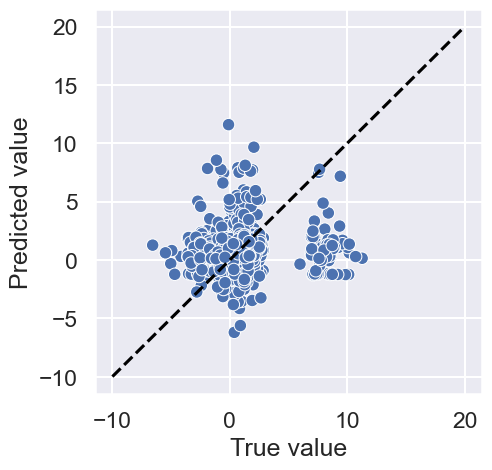

In [15]:
df = pd.read_csv("regression-results_alloy_dataset.csv", sep=";")
df = df[df.model == "gpt-4o"]

# plot y by yhat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("talk")

plt.figure(figsize=(5, 5))
sns.scatterplot(data=df, x="y", y="yhat", hue="model", style="model")
plt.plot([-10, 20], [-10, 20], color="black", linestyle="--")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.legend().remove()
plt.show()


In [16]:
# Quick test of the last regression experiment
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error


lim=(min(y)-1,max(y)+1)
# lim=(-20,40)
plt.plot(lim, lim)
plt.xlim(lim)
plt.ylim(lim)
# plt.scatter(X_test[:,0], [yhi.mean() for yhi in yhat], color="red", alpha=0.2)
# plt.scatter(X_test[:,0], y, color="blue", alpha=0.2)
# plt.scatter(X_train[:,0],train_data['completion'].to_list(), color="green", alpha=0.2)
plt.scatter(y, [yhi.mean() for yhi in yhat], color="red", alpha=0.2)
plt.scatter(train_data['completion'].to_list(),train_data['completion'].to_list())
# plt.errorbar(y, 
#             [yhi.mean() for yhi in yhat], 
#             yerr=[yhi.std() for yhi in yhat],
#             fmt='.', color='gray', alpha=0.4)
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"correlation = {np.corrcoef(y, [yhi.mean() for yhi in yhat])[0,1]:.3f}")
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"MAE = {mean_absolute_error(y, [yhi.mean() for yhi in yhat]):.3f}")

NameError: name 'y' is not defined

# Plot results

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import uncertainty_toolbox as uct
import matplotlib as mpl
import matplotlib.font_manager as font_manager
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9',
            'grid.color' : '#AAAAAA',
            'axes.edgecolor':'#333333',
            'figure.facecolor':'#FFFFFF',
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True
           })

## Loading results

In [18]:
df = pd.read_csv("regression-results_alloy_dataset.csv", sep=';')
# df = pd.read_csv("ocm-regression-results1.csv", sep=';')
df.columns

Index(['y', 'yhat', 'yprobs', 'data', 'model', 'Temperature', 'k_selected',
       'N_train', 'model_class', 'n_tokens', 'x'],
      dtype='object')

In [19]:
df[(df['data'] == 'alloy')].groupby(['Temperature', 'data', 'k_selected', 'model_class', "N_train", "model"]).size().reset_index().sort_values(by=["model_class", "Temperature"])


,Temperature,data,k_selected,model_class,N_train,model,0
0,0.7,alloy,5,topk,1,gpt-3.5-turbo-0125,400
1,0.7,alloy,5,topk,1,gpt-4-0125-preview,400
2,0.7,alloy,5,topk,1,gpt-4o,400
3,0.7,alloy,5,topk,1,knn,1800
4,0.7,alloy,5,topk,1,krr,600
5,0.7,alloy,5,topk,2,gpt-3.5-turbo-0125,200
6,0.7,alloy,5,topk,2,gpt-4-0125-preview,200
7,0.7,alloy,5,topk,2,gpt-4o,200
8,0.7,alloy,5,topk,2,knn,200
9,0.7,alloy,5,topk,2,krr,200


## Plotting

### Utils

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import log_loss

def mse(y, pred):
  # return np.mean((y-pred)**2)
  return mean_squared_error(y, pred)

def mae(y, pred):
  return mean_absolute_error(y, pred)

def r2(y, pred):
  return r2_score(y, pred)

def corr(y, pred):
  return np.corrcoef(y, pred)[0,1]

def acc(y, pred, threshold):
  acc = sum((abs(pred - y)<threshold))/len(pred)
  return acc

def log_likelihood(y, pred, ystd, eps=0):
  y = np.array(y)
  pred = np.array(pred)
  ystd = np.array(ystd)
  yvar = ystd**2 + eps
  neg_ll = 0.5 * (np.log(yvar) + ((y - pred)**2 / yvar))
  return np.sum(neg_ll)/len(y)

def select_df(df, data, k, T, model, model_class, N):
  config = {'k': k,
            'T': T,
            'data': data,
            'model': model,
            'model_class': model_class,
            'N': N,
            }

  q = f""
  if T != 'any':
    q += f"Temperature=={T} and "
  if k != 'any':  
    q+= f"k_selected=={k} and "
  if model != 'any': 
    q+= f"model=='{model}' and "
  q+= f"model_class=='{model_class}' and "
  if N != 'any':
    q+= f"N_train=={N} and "
  q += f"data=='{data}'"
  sel = df.query(q)
  if sel.empty:
    raise ValueError(f"Dataframe is empty for the configuration {config}")
  return sel

In [21]:
def plot_parities(df, data_property, data_range, nrows, ncols, data=None, k=None, T=None, model=None, model_class=None, N=None, axis_name=None, calibration=None, recal_ind=1, out_name=None, GPR=False):
  config = {'k': k,
            'T': T,
            'data': data,
            'model': model,
            'model_class': model_class,
            'N': N,
            }

  if sum([1 for i in config.values() if i is None]) > 1:
    raise ValueError("Only the property being varied in data_range can me passed as None.")

  if nrows*ncols < len(data_range):
    raise ValueError('''There's not enough space to plat all data in data_range.
    Decrease the size of data_range or increase ncols or nrows.''')

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=False, figsize=(12, 4), dpi=600)
  for i, p in enumerate(data_range):
    config[data_property] = p
    y=[]
    yhat=[]
    yprob=[]
    ax = axs if ncols*nrows == 1 else axs.flatten()[i]

    df_sel = select_df(df, **config)

    for prompt in df_sel['x'].unique():
        y.append(df_sel[df_sel['x']==prompt]['y'].unique()[0])
        # max_p = np.argmax(df_sel[df_sel['y']==d]['yprobs'].values)
        yhat.append(df_sel[df_sel['x']==prompt]['yhat'].values)
        yprob.append(df_sel[df_sel['x']==prompt]['yprobs'].values)
    yprobs = [yhi.std() for yhi in yhat]
    if GPR:
        ymeans = np.array([yhi.mean() for yhi in yhat])
        ystds = np.array([ypi.mean() for ypi in yprob])
    else:
        ymeans = np.array([
                  np.sum(yhi*ypi) if len(yhi)>1 else yhi.mean()
                  for yhi,ypi in zip(yhat, yprob)
                ])
        ystds = np.array([
                  np.sqrt(np.sum((yhi-ymi)**2*ypi)) if np.sum((yhi-ymi)**2*ypi)>1 else 0.1 #ypi.mean()
                  for yhi,ypi,ymi in zip(yhat, yprob, ymeans)
                ])

    if calibration:
        if calibration == "scaling_factor":
          std_scaling = uct.recalibration.optimize_recalibration_ratio(ymeans[:recal_ind], ystds[:recal_ind], np.array(y[:recal_ind]),
                                                                        criterion="miscal")
          ystds = ystds * std_scaling
        elif calibration == "isotonic":
          exp_props, obs_props= uct.metrics_calibration.get_proportion_lists_vectorized(ymeans[:recal_ind], ystds[:recal_ind], np.array(y[:recal_ind]))
          recal_model = uct.recalibration.iso_recal(exp_props, obs_props)
          recal_bounds = uct.metrics_calibration.get_prediction_interval(ymeans, ystds, 0.95, recal_model)
          ystds=np.array([ymeans - recal_bounds.lower,
                 recal_bounds.upper - ymeans])

    ax.plot(y,y)
    ax.errorbar(y, 
                ymeans, 
                yerr=ystds,
                fmt='.', color='gray', alpha=0.3)
    ax.scatter(
        y, ymeans, s=6, alpha=1, color=f"C{i}"
    )
    
    ax.set_title(f"{data_property}={p}")

    lim = (min(y), max(y))
    
    if model_class in ["KRR", "KNN"]:
       metrics = {
          "accuracy": uct.metrics.get_all_accuracy_metrics(ymeans, np.array(y), verbose=False)
                  }
    else:
        metrics = uct.metrics.get_all_metrics(ymeans, ystds, np.array(y), verbose=False)
    ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"$(\\uparrow$)correlation = {metrics['accuracy']['corr']:.3f}")
    if model_class not in ["KRR", "KNN"]:
      ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"$(\\downarrow$)neg-ll = {metrics['scoring_rule']['nll']:.3f}")
    ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 3*0.1*(max(y)-min(y)), f"$(\\downarrow$)MAE = {metrics['accuracy']['mae']:.3f}")

    ax.set_ylim(lim[0],lim[1])
    ax.set_xlim(lim[0],lim[1])

    ax.set_xlabel(f"measured {axis_name}")
    if (i%ncols==0):
      ax.set_ylabel(f"predicted {axis_name}")

  # plt.tight_layout()
  plt.show()
  # if (out_name):
  #   plt.savefig(f"figs/{out_name}", dpi=300)

In [22]:
def plot_ablation(df, data_property, data_range, nrows, ncols, data=None, k=None, T=None, model=None, model_class=None, N=None, out_name=None, GPR=False):
  config = {'k': k,
            'T': T,
            'data': data,
            'model': model,
            'model_class': model_class,
            'N': N,
            }

  MAE_list = []
  RMSE_list = []
  r_list = []
  nll_list = []
  prop_list = []
  for i, p in enumerate(data_range):
    config[data_property] = p
    y=[]
    yhat=[]
    yprobs=[]
    yprob=[]	

    df_sel = select_df(df, **config)

    for prompt in df_sel['x'].unique():
        y.append(df_sel[df_sel['x']==prompt]['y'].unique()[0])
        # max_p = np.argmax(df_sel[df_sel['y']==d]['yprobs'].values)
        yhat.append(df_sel[df_sel['x']==prompt]['yhat'].values)
        yprob.append(df_sel[df_sel['x']==prompt]['yprobs'].values)
    yprobs = [yhi.std() for yhi in yhat]
    if GPR:
        ymeans = np.array([yhi.mean() for yhi in yhat])
        ystds = np.array([ypi.mean() for ypi in yprob])
    else:
        ymeans = np.array([
                  np.sum(yhi*ypi) if len(yhi)>1 else yhi.mean()
                  for yhi,ypi in zip(yhat, yprob)
                ])
        ystds = np.array([
                  np.sqrt(np.sum((yhi-ymi)**2*ypi)) if yhi.std()>1 else ypi.mean()
                  for yhi,ypi,ymi in zip(yhat, yprob, ymeans)
                ])

    metrics = uct.metrics.get_all_metrics(ymeans, ystds, np.array(y), verbose=False)
    r_list.append(metrics['accuracy']['corr'])
    RMSE_list.append(metrics['accuracy']['rmse'])
    MAE_list.append(metrics['accuracy']['mae'])
    nll_list.append(metrics['scoring_rule']['nll'])
    prop_list.append(p)
    print(f"{model_class}(N:{config['N']}/k:{config['k']}/T:{config['T']}) => RMSE: | MAE: {MAE_list[-1]} | r: {r_list[-1]} | nll: {nll_list[-1]}")

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=False, figsize=(4*ncols, 4*nrows), dpi=300)
  
  axs[0].plot(prop_list, MAE_list)
  axs[0].set_xlabel(data_property)
  axs[0].set_ylabel("$\\rightarrow$MAE")
  
  axs[1].plot(prop_list, r_list)
  axs[1].set_xlabel(data_property)
  axs[1].set_ylabel("$\\leftarrow$correlation")

  axs[2].plot(prop_list, nll_list)
  axs[2].set_xlabel(data_property)
  axs[2].set_yscale('log')
  axs[2].set_ylabel("$\\rightarrow$negative log-likelihood")

  plt.tight_layout()
  # plt.show()
  if (out_name):
    plt.savefig(f"figs/{out_name}", dpi=300)

In [23]:
def get_sub_ablation_data(df, data_property, data_range, data=None, k=None, T=None, model=None, model_class=None, N=None, GPR=False):
  config = {'k': k,
          'T': T,
          'data': data,
          'model': model,
          'model_class': model_class,
          'N': N,
          }
   
  MAE_list = []
  RMSE_list = []
  r_list = []
  nll_list = []
  prop_list = []
  for i, p in enumerate(data_range):
    config[data_property] = p
    y=[]
    yhat=[]
    yprobs=[]
    yprob=[]

    df_sel = select_df(df, **config)

    for prompt in df_sel['x'].unique():
        y.append(df_sel[df_sel['x']==prompt]['y'].unique()[0])
        # max_p = np.argmax(df_sel[df_sel['y']==d]['yprobs'].values)
        yhat.append(df_sel[df_sel['x']==prompt]['yhat'].values)
        yprob.append(df_sel[df_sel['x']==prompt]['yprobs'].values)
    yprobs = [yhi.std() for yhi in yhat]
    if GPR:
        ymeans = np.array([yhi.mean() for yhi in yhat])
        ystds = np.array([ypi.mean() for ypi in yprob])
    else:
        ymeans = np.array([
                  np.sum(yhi*ypi) if len(yhi)>1 else yhi.mean()
                  for yhi,ypi in zip(yhat, yprob)
                ])
        ystds = np.array([
                  np.sqrt(np.sum((yhi-ymi)**2*ypi)) if np.sum((yhi-ymi)**2*ypi)>0 else 10
                  for yhi,ypi,ymi in zip(yhat, yprob, ymeans)
                ])

    if model_class in ["KRR", "KNN"]:
       metrics = {
          "accuracy": uct.metrics.get_all_accuracy_metrics(ymeans, np.array(y), verbose=False)
                  }
    else:
      metrics = uct.metrics.get_all_metrics(ymeans, ystds, np.array(y), verbose=False)
      nll_list.append(metrics['scoring_rule']['nll'])
    r_list.append(metrics['accuracy']['corr'])
    RMSE_list.append(metrics['accuracy']['rmse'])
    MAE_list.append(metrics['accuracy']['mae'])
    prop_list.append(p)
    with open("Table.tex", "a") as t:
      t.write(f"{config['data']}&{model_class}&{model}&{config['T']}&{config['k']}&{config['N']}&{RMSE_list[-1]}&{MAE_list[-1]}&{r_list[-1]}&{nll_list[-1] if nll_list else '-'}&\\\\\n")
    # print(f"{model_class}(N:{config['N']}/k:{config['k']}/T:{config['T']}) => RMSE: | MAE: {MAE_list[-1]} | r: {r_list[-1]} | nll: {nll_list[-1]}")
   
  return prop_list, MAE_list, r_list, nll_list

def create_sub_ablation(axs, df, lims, data_property, data_range, color='C0', data=None, k=None, T=None, model=None, model_class=None, N=None, label=False, GPR=False):
  config = {'k': k,
            'T': T,
            'data': data,
            'model': model,
            'model_class': model_class,
            'N': N,
            }

  prop_list, MAE_list, r_list, nll_list = get_sub_ablation_data(df, data_property, data_range, **config, GPR=GPR)

  for ax in axs:
    ax.label_outer()

  if label:
    if model_class=="GPR-BOT":
      axs[0].plot(prop_list, MAE_list, label="GPR", color=color)
    else:
      axs[0].plot(prop_list, MAE_list, label=model_class, color=color)
  else:
    axs[0].plot(prop_list, MAE_list, color=color)
  axs[0].set_ylabel("MAE\n$\leftarrow$")
  axs[0].set_ylim(lims[0])
  axs[0].set_label(model_class)
  
  axs[1].plot(prop_list, r_list, color=color)
  axs[1].set_xlabel(data_property)
  axs[1].set_ylabel("r\n$\\rightarrow$")
  axs[1].set_ylim(lims[1])
  axs[1].set_label(model_class)

  if False: #model_class not in ["KRR", "KNN"]:
    axs[2].plot(prop_list, nll_list, color=color)
    axs[2].set_xlabel(data_property)
    axs[2].set_yscale('log')
    axs[2].set_ylabel("neg-ll\n$\leftarrow$")
    # axs[1].set_label(model_class)

  for ax in axs:
    ax.label_outer()

In [24]:
def create_sub_shadow(axs, df, lims, data_property, data_range, color='C0', data=None, k=None, T=None, model=None, model_class=None, N=None, label=False, GPR=False):

    all_MAE = []
    all_r = []
    config = {'k': k,
            'T': T,
            'data': data,
            'model': model,
            'model_class': model_class,
            'N': N,
            }

    for i in range(1, 6):  # Loop through the 5 CSV files
        df = pd.read_csv(f"{data}-regression-results{i}.csv", sep=';')
        df_sel = select_df(df, **config)
        
        prop_list, MAE_list, r_list, nll_list = get_sub_ablation_data(df_sel, data_property, data_range, data=data, k=k, T=T, model=model, model_class=model_class, N=N)

        all_MAE.append(MAE_list)
        all_r.append(r_list)

    all_MAE = np.array(all_MAE)
    all_r = np.array(all_r)

    # Compute average MAE and r
    avg_MAE = np.mean(all_MAE, axis=0)
    avg_r = np.mean(all_r, axis=0)

    # Compute min and max for uncertainty region
    min_MAE = np.min(all_MAE, axis=0)
    max_MAE = np.max(all_MAE, axis=0)
    min_r = np.min(all_r, axis=0)
    max_r = np.max(all_r, axis=0)

    # Plot average curve with uncertainty region
    axs[0].fill_between(prop_list, min_MAE, max_MAE, color=color, alpha=0.3)
    axs[0].plot(prop_list, avg_MAE, color=color)
    axs[0].set_ylabel("MAE\n$\leftarrow$")
    axs[0].set_ylim(lims[0])
    axs[0].legend()

    axs[1].fill_between(prop_list, min_r, max_r, color=color, alpha=0.3)
    axs[1].plot(prop_list, avg_r, color=color)
    axs[1].set_ylabel("r\n$\\rightarrow$")
    axs[1].set_ylim(lims[1])
    axs[1].legend()

    axs[1].set_xlabel(data_property)

    for ax in axs:
        ax.label_outer()

In [25]:
def get_sub_parity_data():
   pass
   

def create_sub_parity(ax, df_sel, axis_name, model_class, lim=[-1,1], color='gray', GPR=False, title=None, calibration=None, recal_ind=0):
    y=[]
    yhat=[]
    yprob=[]
    for prompt in df_sel['x'].unique():
        y.append(df_sel[df_sel['x']==prompt]['y'].unique()[0])
        # max_p = np.argmax(df_sel[df_sel['y']==d]['yprobs'].values)
        yhat.append(df_sel[df_sel['x']==prompt]['yhat'].values)
        yprob.append(df_sel[df_sel['x']==prompt]['yprobs'].values)
    yprobs = [yhi.std() for yhi in yhat]
    if GPR:
        ymeans = np.array([yhi.mean() for yhi in yhat])
        ystds = np.array([ypi.mean() for ypi in yprob])
    else:
        ymeans = np.array([
                  np.sum(yhi*ypi) if len(yhi)>1 else yhi.mean()
                  for yhi,ypi in zip(yhat, yprob)
                ])
        ystds = np.array([
                  np.sqrt(np.sum((yhi-ymi)**2*ypi)) if len(yhi)>1 else ypi.mean()
                  for yhi,ypi,ymi in zip(yhat, yprob, ymeans)
                ])
        # hack to fix uncertainties in finetuned model. 3.559 is the training set (N=1000) std
        ystds = np.array([ysi if ysi!=10 else 3.559 for ysi in ystds]) 
  
    if calibration:
        if calibration == "scaling_factor":
          std_scaling = uct.recalibration.optimize_recalibration_ratio(ymeans[:recal_ind], ystds[:recal_ind], np.array(y[:recal_ind]),
                                                                        criterion="miscal")
          ystds = ystds * std_scaling
        elif calibration == "isotonic":
          exp_props, obs_props= uct.metrics_calibration.get_proportion_lists_vectorized(ymeans[:recal_ind], ystds[:recal_ind], np.array(y[:recal_ind]))
          recal_model = uct.recalibration.iso_recal(exp_props, obs_props)
          recal_bounds = uct.metrics_calibration.get_prediction_interval(ymeans, ystds, 0.95, recal_model)
          ystds=np.array([ymeans - recal_bounds.lower,
                 recal_bounds.upper - ymeans])

    if model_class in ["KRR", "KNN"] or calibration=="isotonic":
       metrics = {
          "accuracy": uct.metrics.get_all_accuracy_metrics(ymeans, np.array(y), verbose=False)
                  }
    else:
      metrics = uct.metrics.get_all_metrics(ymeans, ystds, np.array(y), verbose=False)
      ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"$(\\downarrow$)neg-ll = {metrics['scoring_rule']['nll']:.3f}")
    ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"$(\\uparrow$)correlation = {metrics['accuracy']['corr']:.3f}")
    ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 3*0.1*(max(y)-min(y)), f"$(\\downarrow$)MAE = {metrics['accuracy']['mae']:.3f}")

    # with open("Table.tex", "a") as t:
    #   t.write(f"{config['data']}&{model_class}&{model}&{config['T']}&{config['k']}&{config['N']}&{RMSE_list[-1]}&{MAE_list[-1]}&{r_list[-1]}&{nll_list[-1] if nll_list else '-'}&\\\\\n")
    # print(f"{model_class}(N:{config['N']}/k:{config['k']}/T:{config['T']}) => RMSE: | MAE: {MAE_list[-1]} | r: {r_list[-1]} | nll: {nll_list[-1]}")
    print(metrics['accuracy']['rmse'])

    ax.set_xlabel(f"measured {axis_name}")
    ax.set_ylabel(f"predicted {axis_name}")
    ax.set_ylim(lim[0],lim[1])
    ax.set_xlim(lim[0],lim[1])
    ax.set_xticks(np.arange(lim[0],lim[1]+0.1,4.0))

    if title:
      ax.set_title(title)

    ax.plot(y,y)
    ax.plot(lim,lim)
    if model_class not in ["KRR", "KNN"]:
      ax.errorbar(y, 
                  ymeans, 
                  yerr=ystds,
                  fmt='.', color='gray', alpha=0.2)
    ax.scatter(
        y, ymeans, s=6, alpha=1, color=color
    )

### Paper Figures

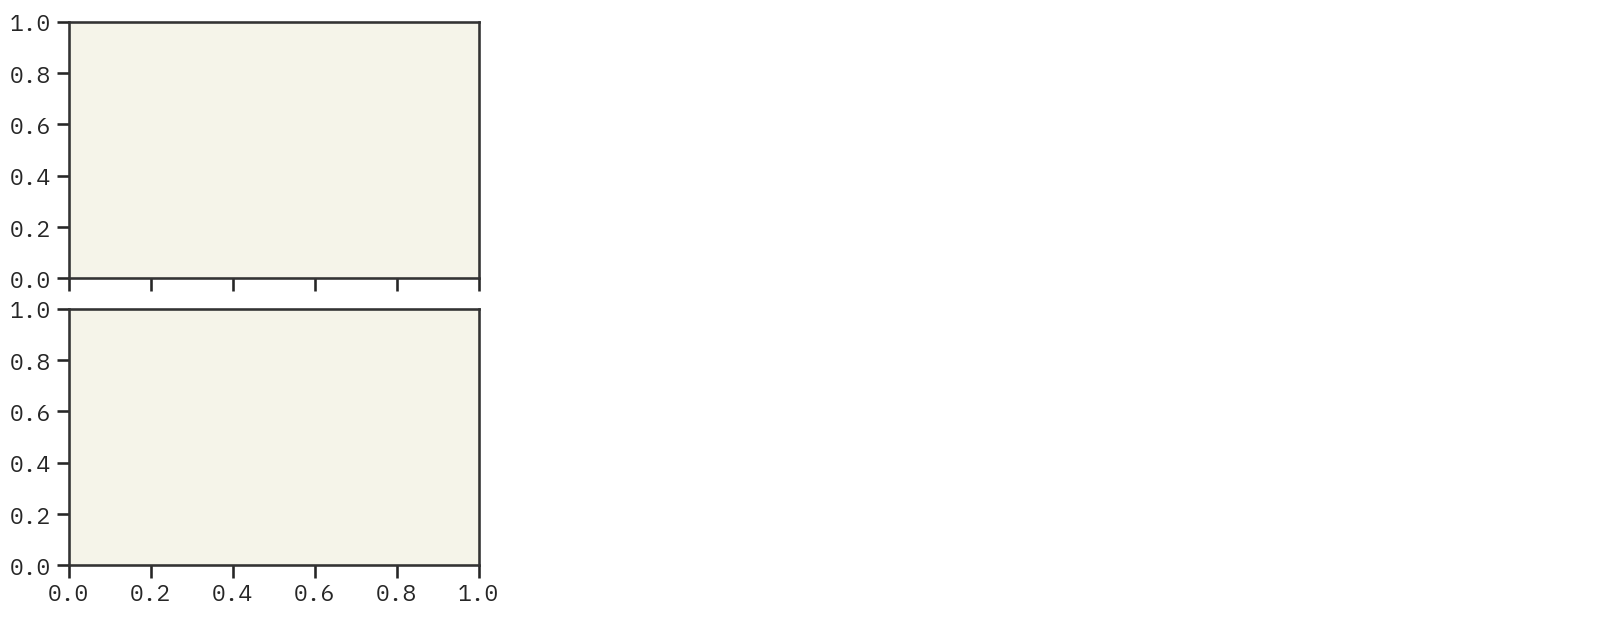

In [35]:
import numpy as np
import matplotlib.pyplot as plt

data = "alloy"
max_N=1000

fig = plt.figure(figsize=(16,6), constrained_layout=True)
subfigs = fig.subfigures(1,3, wspace=0.1, hspace=0.1)

lims = [(0,5),(0,1),(-1,1)]

sub00 = subfigs[0].subplots(2,1, sharex=True, sharey=False)
df1 = pd.read_csv(f"{data}-regression-results1.csv", sep=';')
d01 = select_df(df1, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
# create_sub_ablation(sub00, d01, lims, 'N', sorted(d01['N_train'].unique()), data=data, color='C1', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N=None, label=False)
# df2 = pd.read_csv(f"{data}-regression-results2.csv", sep=';')
# d02 = select_df(df2, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
# create_sub_ablation(sub00, d02, lims, 'N', sorted(d02['N_train'].unique()), data=data, color='C2', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N=None, label=False)
# df3 = pd.read_csv(f"{data}-regression-results3.csv", sep=';')
# d03 = select_df(df3, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
# create_sub_ablation(sub00, d03, lims, 'N', sorted(d03['N_train'].unique()), data=data, color='C3', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N=None, label=False)
# df4 = pd.read_csv(f"{data}-regression-results4.csv", sep=';')
# d04 = select_df(df4, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
# create_sub_ablation(sub00, d04, lims, 'N', sorted(d04['N_train'].unique()), data=data, color='C4', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N=None, label=False)
# df5 = pd.read_csv(f"{data}-regression-results5.csv", sep=';')
# d05 = select_df(df5, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
# create_sub_ablation(sub00, d05, lims, 'N', sorted(d05['N_train'].unique()), data=data, color='C5', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N=None, label=False)


# # sub02 = subfigs[1].subplots(2,1, sharex=True, sharey=False)
# # df1 = pd.read_csv(f"{data}-regression-results1.csv", sep=';')
# # d01 = select_df(df1, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10)
# # create_sub_ablation(sub02, d01, lims, 'k', sorted(d01['k_selected'].unique()), data=data, color='C1', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10, label=False)
# # df2 = pd.read_csv(f"{data}-regression-results2.csv", sep=';')
# # d02 = select_df(df2, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10)
# # create_sub_ablation(sub02, d02, lims, 'k', sorted(d02['k_selected'].unique()), data=data, color='C2', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10, label=False)
# # df3 = pd.read_csv(f"{data}-regression-results3.csv", sep=';')
# # d03 = select_df(df3, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10)
# # create_sub_ablation(sub02, d03, lims, 'k', sorted(d03['k_selected'].unique()), data=data, color='C3', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10, label=False)
# # df4 = pd.read_csv(f"{data}-regression-results4.csv", sep=';')
# # d04 = select_df(df4, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10)
# # create_sub_ablation(sub02, d04, lims, 'k', sorted(d04['k_selected'].unique()), data=data, color='C4', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10, label=False)
# # df5 = pd.read_csv(f"{data}-regression-results5.csv", sep=';')
# # d05 = select_df(df5, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10)
# # create_sub_ablation(sub02, d05, lims, 'k', sorted(d05['k_selected'].unique()), data=data, color='C5', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10, label=False)

# sub03 = subfigs[2].subplots(2,1, sharex=True, sharey=False)
# df1 = pd.read_csv(f"{data}-regression-results1.csv", sep=';')
# d01 = select_df(df1, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
# create_sub_ablation(sub03, d01, lims, 'T', sorted(d01['Temperature'].unique()), data=data, color='C1', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
# df2 = pd.read_csv(f"{data}-regression-results2.csv", sep=';')
# d02 = select_df(df2, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
# create_sub_ablation(sub03, d02, lims, 'T', sorted(d02['Temperature'].unique()), data=data, color='C2', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
# df3 = pd.read_csv(f"{data}-regression-results3.csv", sep=';')
# d03 = select_df(df3, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
# create_sub_ablation(sub03, d03, lims, 'T', sorted(d03['Temperature'].unique()), data=data, color='C3', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
# df4 = pd.read_csv(f"{data}-regression-results4.csv", sep=';')
# d04 = select_df(df4, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
# create_sub_ablation(sub03, d04, lims, 'T', sorted(d04['Temperature'].unique()), data=data, color='C4', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)
# df5 = pd.read_csv(f"{data}-regression-results5.csv", sep=';')
# d05 = select_df(df5, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
# create_sub_ablation(sub03, d05, lims, 'T', sorted(d05['Temperature'].unique()), data=data, color='C5', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)


# fig.legend(loc='upper center', bbox_to_anchor=(0.5 ,0),
#           fancybox=True, shadow=True, ncol=6)

# plt.tight_layout()
# plt.savefig(f"figs/metrics", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = "ocm"
max_N = 1000

fig = plt.figure(figsize=(16,6), constrained_layout=True)
subfigs = fig.subfigures(1,3, wspace=0.1, hspace=0.1)

lims = [(0,5),(0,1),(-1,1)]

sub00 = subfigs[0].subplots(2,1, sharex=True, sharey=False)
df1 = pd.read_csv(f"{data}-regression-results1.csv", sep=';')
d01 = select_df(df1, data=data, k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any')
create_sub_shadow(sub00, d01, lims, 'N', sorted(d01['N_train'].unique()), data=data, color='C1', k=5, T=0.7, model='gpt-3.5-turbo-0125', model_class='topk', N='any', label=False)

sub02 = subfigs[1].subplots(2,1, sharex=True, sharey=False)
df1 = pd.read_csv(f"{data}-regression-results1.csv", sep=';')
d01 = select_df(df1, data=data, k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10)
create_sub_shadow(sub02, d01, lims, 'k', sorted(d01['k_selected'].unique()), data=data, color='C1', k='any', T=0.05, model='gpt-3.5-turbo-0125', model_class='topk', N=10, label=False)

sub03 = subfigs[2].subplots(2,1, sharex=True, sharey=False)
df1 = pd.read_csv(f"{data}-regression-results1.csv", sep=';')
d01 = select_df(df1, data=data, k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N)
create_sub_shadow(sub03, d01, lims, 'T', sorted(d01['Temperature'].unique()), data=data, color='C1', k=5, T='any', model='gpt-3.5-turbo-0125', model_class='topk', N=max_N, label=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,8), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1)

d00 = select_df(df, data="iupac-sol", k=5, T=0.7, model='text-davinci-003', model_class='topk', N=700)
lim_sol = (min(d00['y']), max(d00['y']))
lim_sol = (-12,4)
text_anchor = sum(lim_sol)/len(lim_sol)
create_sub_parity(axs[0,0], d00, 'LogS solubility', lim=lim_sol, model_class="topk", color=f'C0', calibration="scaling_factor", recal_ind=300)

d01 = select_df(df, data="iupac-sol", k=5, T=0.7, model='gpt-4', model_class='topk', N=700)
create_sub_parity(axs[0,1], d01, 'LogS solubility', lim=lim_sol, model_class="topk", color=f'C1', calibration="scaling_factor", recal_ind=300)

d02 = select_df(df, data="iupac-sol", k=0, T=0.05, model='any', model_class='finetune', N=700)
create_sub_parity(axs[0,2], d02, 'LogS solubility', lim=lim_sol, model_class="finetune", color=f'C2', calibration="scaling_factor", recal_ind=300)

d03 = select_df(df, data="iupac-sol", k=32, T=0.05, model='text-ada-001', model_class='GPR-BOT', N=700)
create_sub_parity(axs[0,3], d03, 'LogS solubility', lim=lim_sol, model_class="GPR", color=f'C3', GPR=True, calibration="scaling_factor", recal_ind=300)


d10 = select_df(df, data="C2", k=5, T=0.7, model='text-davinci-003', model_class='topk', N=1000)
lim_c2 = (min(d10['y']), max(d10['y']))
lim_c2 = (-2, 25)
create_sub_parity(axs[1,0], d10, 'C2 yield', lim=lim_c2, model_class="topk", color=f'C4', calibration="scaling_factor", recal_ind=300)

d11 = select_df(df, data="C2", k=5, T=0.7, model='gpt-4', model_class='topk', N=1000)
create_sub_parity(axs[1,1], d11, 'C2 yield', lim=lim_c2, model_class="topk", color=f'C5', calibration="scaling_factor", recal_ind=300)

d12 = select_df(df, data="C2", k=0, T=0.05, model='any', model_class='finetune', N=1000)
create_sub_parity(axs[1,2], d12, 'C2 yield', lim=lim_c2, model_class="finetune", color=f'C6', calibration="scaling_factor", recal_ind=300)

d13 = select_df(df, data="C2", k=32, T=0.05, model='text-ada-001', model_class='GPR-BOT', N=1000)
create_sub_parity(axs[1,3], d13, 'C2 yield', lim=lim_c2, model_class="GPR", color=f'C7', GPR=True, calibration="scaling_factor", recal_ind=300)

anchor_x = (lim_sol[1]+lim_sol[0])/2
anchor_y = lim_sol[1] + 1
bbox_props = dict(boxstyle="square", fc='#f5f4e9', ec="gray", lw=1)
axs[0,0].text(anchor_x, anchor_y, "davinci", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)
axs[0,1].text(anchor_x, anchor_y, "GPT-4", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)
axs[0,2].text(anchor_x, anchor_y, "Finetune", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)
axs[0,3].text(anchor_x, anchor_y, "GPR", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)

axs[0,0].text(lim_sol[0]-5, (lim_sol[1]+lim_sol[0])/2, "Solubility", ha="right", va="center", rotation=0,
            size=15, bbox=bbox_props)
axs[1,0].text(lim_c2[0]-7, (lim_c2[1]+lim_c2[0])/2, "C2 yield", ha="right", va="center", rotation=0,
            size=15, bbox=bbox_props)

plt.savefig(f"figs/parities", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#figsize=(6.4,4.8)
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,8), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1)

# plot axs[0,0]
d00 = select_df(df, data="iupac-sol", k=5, T=0.7, model='text-davinci-003', model_class='topk', N=700)
lim_sol = (min(d00['y']), max(d00['y']))
lim_sol = (-12,4)
text_anchor = sum(lim_sol)/len(lim_sol)
create_sub_parity(axs[0], d00, 'LogS solubility', lim=lim_sol, model_class="topk", color=f'C0', calibration="scaling_factor", recal_ind=300)
# plot axs[0,1]
d01 = select_df(df, data="iupac-sol", k=5, T=0.7, model='gpt-4', model_class='topk', N=700)
create_sub_parity(axs[1], d01, 'LogS solubility', lim=lim_sol, model_class="topk", color=f'C1', calibration="scaling_factor", recal_ind=300)
# plot axs[0,2]
d02 = select_df(df, data="iupac-sol", k=0, T=0.05, model='any', model_class='finetune', N=700)
create_sub_parity(axs[2], d02, 'LogS solubility', lim=lim_sol, model_class="finetune", color=f'C2', calibration="scaling_factor", recal_ind=300)
# plot axs[0,3]
d03 = select_df(df, data="iupac-sol", k=32, T=0.05, model='text-ada-001', model_class='GPR-BOT', N=700)
create_sub_parity(axs[3], d03, 'LogS solubility', lim=lim_sol, model_class="GPR", color=f'C3', GPR=True, calibration="scaling_factor", recal_ind=300)

anchor_x = (lim_sol[1]+lim_sol[0])/2
anchor_y = lim_sol[1] + 1
bbox_props = dict(boxstyle="square", fc='#f5f4e9', ec="gray", lw=1)
axs[0].text(anchor_x, anchor_y, "davinci", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)
axs[1].text(anchor_x, anchor_y, "GPT-4", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)
axs[2].text(anchor_x, anchor_y, "Finetune", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)
axs[3].text(anchor_x, anchor_y, "GPR", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)

axs[0].text(lim_sol[0]-5, (lim_sol[1]+lim_sol[0])/2, "Solubility", ha="right", va="center", rotation=0,
            size=15, bbox=bbox_props)

plt.savefig(f"figs/parities-sol", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,8), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1)

d10 = select_df(df, data="C2", k=5, T=0.7, model='text-davinci-003', model_class='topk', N=1000)
lim_c2 = (min(d10['y']), max(d10['y']))
lim_c2 = (-2, 25)
create_sub_parity(axs[0], d10, 'C2 yield', lim=lim_c2, model_class="topk", color=f'C4', calibration="scaling_factor", recal_ind=300)
d11 = select_df(df, data="C2", k=5, T=0.7, model='gpt-4', model_class='topk', N=1000)
create_sub_parity(axs[1], d11, 'C2 yield', lim=lim_c2, model_class="topk", color=f'C5', calibration="scaling_factor", recal_ind=300)
d12 = select_df(df, data="C2", k=0, T=0.05, model='any', model_class='finetune', N=1000)
create_sub_parity(axs[2], d12, 'C2 yield', lim=lim_c2, model_class="finetune", color=f'C6', calibration="scaling_factor", recal_ind=300)
d13 = select_df(df, data="C2", k=32, T=0.05, model='text-ada-001', model_class='GPR-BOT', N=1000)
create_sub_parity(axs[3], d13, 'C2 yield', lim=lim_c2, model_class="GPR", color=f'C7', GPR=True, calibration="scaling_factor", recal_ind=300)


anchor_x = (lim_c2[1]+lim_c2[0])/2
anchor_y = lim_c2[1] + 1
bbox_props = dict(boxstyle="square", fc='#f5f4e9', ec="gray", lw=1)
axs[0].text(anchor_x, anchor_y, "davinci", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)
axs[1].text(anchor_x, anchor_y, "GPT-4", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)
axs[2].text(anchor_x, anchor_y, "Finetune", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)
axs[3].text(anchor_x, anchor_y, "GPR", ha="center", va="bottom", rotation=0,
            size=15, bbox=bbox_props)

axs[0].text(lim_c2[0]-7, (lim_c2[1]+lim_c2[0])/2, "C2 yield", ha="right", va="center", rotation=0,
            size=15, bbox=bbox_props)

plt.savefig(f"figs/parities-C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1)

d00 = select_df(df, data="C2", k=5, T=0.7, model='text-curie-001', model_class='topk', N=1000)
lim_c2 = (min(d00['y']), max(d00['y']))
lim_c2 = (-2, 25)
text_anchor = sum(lim_c2)/len(lim_c2)
create_sub_parity(axs[0,0], d00, 'C2 yield', lim=lim_c2, model_class="topk", color=f'C0', title="curie")
d01 = select_df(df, data="C2", k=5, T=0.7, model='text-davinci-003', model_class='topk', N=1000)
create_sub_parity(axs[0,1], d01, 'C2 yield', lim=lim_c2, model_class="topk", color=f'C1', title="davinci")
d02 = select_df(df, data="C2", k=5, T=0.7, model='gpt-4', model_class='topk', N=1000)
create_sub_parity(axs[0,2], d02, 'C2 yield', lim=lim_c2, model_class="topk", color=f'C2', title="GPT-4")

d10 = select_df(df, data="C2", k=1, T=0.05, model='text-ada-001', model_class='KNN', N=1000)
create_sub_parity(axs[1,0], d10, 'C2 yield', lim=lim_c2, model_class="KNN", color=f'C4', title="KNN")
d11 = select_df(df, data="C2", k=0, T=0.05, model='text-ada-001', model_class='KRR', N=1000)
create_sub_parity(axs[1,1], d11, 'C2 yield', lim=lim_c2, model_class="KRR", color=f'C5', title="KRR")
d12 = select_df(df, data="C2", k=0, T=0.05, model='any', model_class='finetune', N=1000)
create_sub_parity(axs[1,2], d12, 'C2 yield', lim=lim_c2, model_class="finetune", color=f'C6', title="finetune")

plt.savefig(f"figs/par_models", dpi=300, bbox_inches='tight')
plt.show()

### C2

In [ ]:
c2_data = df[(df['data'] == 'ocm')]
c2_data.groupby(['Temperature', 'data', 'k_selected', 'model_class', "N_train", "model"]).size().reset_index().sort_values(by=["model_class", "Temperature"])

#### multi

In [ ]:
plot_parities(c2_data, 
              'N', 
              [1,25,200,1000],#sorted(c2_data[(c2_data['model_class']=="multi") & (c2_data['model']=="text-curie-001")]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='C2',
              k=5,
              T=0.05,
              model='text-curie-001',
              model_class='multi',
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_multi_N_curie.png")

plot_parities(c2_data, 
              'k', 
              [0,1,5], #sorted(c2_data[(c2_data['model_class']=="multi") & (c2_data['model']=="text-curie-001")]['k_selected'].unique()), 
              nrows=1, ncols=3,
              data='C2',
              k=None,
              T=0.05,
              model='text-curie-001',
              model_class='multi',
              N=1000,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_multi_k_curie.png")

plot_parities(c2_data, 
              'T', 
              [0.05, 0.5, 0.7, 1.0], #sorted(c2_data[(c2_data['model_class']=="multi") & (c2_data['model']=="text-curie-001")]['Temperature'].unique()), 
              nrows=1, ncols=4,
              data='C2',
              k=5,
              T=None,
              model='text-curie-001',
              model_class='multi',
              N=1000,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_multi_T_curie.png")

In [ ]:
# plot_ablation(c2_data, 
#               'N', 
#               sorted(c2_data[(c2_data['model_class']=="multi") & (c2_data['model']=="text-curie-001")]['N_train'].unique()), 
#               nrows=1, ncols=3,
#               data='C2',
#               k=5,
#               T=0.05,
#               model='text-curie-001',
#               model_class='multi',
#               N=None,
#               out_name="ablation_C2_multi_N_curie.png")

# plot_ablation(c2_data, 
#               'k', 
#               sorted(c2_data[(c2_data['model_class']=="multi") & (c2_data['model']=="text-curie-001")]['k_selected'].unique()), 
#               nrows=1, ncols=3,
#               data='C2',
#               k=None,
#               T=0.05,
#               model='text-curie-001',
#               model_class='multi',
#               N=1000,
#               out_name="ablation_C2_multi_k_curie.png")

# plot_ablation(c2_data, 
#               'T', 
#               sorted(c2_data[(c2_data['model_class']=="multi") & (c2_data['model']=="text-curie-001")]['Temperature'].unique()), 
#               nrows=1, ncols=3,
#               data='C2',
#               k=5,
#               T=None,
#               model='text-curie-001',
#               model_class='multi',
#               N=1000,
#               out_name="ablation_C2_multi_T_curie.png")



#### multi-davinci

In [ ]:
plot_parities(c2_data, 
              'N', 
              sorted(c2_data[(c2_data['model_class']=="multi") & (c2_data['model']=="text-davinci-003")]['N_train'].unique()), 
              nrows=1, ncols=1,
              data='C2', 
              k=5, 
              T=0.05, 
              model='text-davinci-001',
              model_class='multi', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_multi_N_davinci.png")

plot_parities(c2_data, 
              'T', 
              [0.05, 0.5, 0.7, 1.0], 
              nrows=1, ncols=4,
              data='C2', 
              k=5, 
              T=None, 
              model='text-davinci-003',
              model_class='multi', 
              N=1000,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_multi_T_davinci.png")

In [ ]:
# plot_ablation(c2_data, 
#               'N', 
#               sorted(c2_data[(c2_data['model_class']=="multi") & (c2_data['model']=="text-davinci-003")]['N_train'].unique()), 
#               nrows=1, ncols=3,
#               data='C2',
#               k=5,
#               T=0.05,
#               model='text-davinci-003',
#               model_class='multi',
#               N=None,
#               out_name="ablation_C2_multi_N_davinci.png")

# plot_ablation(c2_data, 
#               'T', 
#               sorted(c2_data[(c2_data['model_class']=="multi") & (c2_data['model']=="text-davinci-003")]['Temperature'].unique()), 
#               nrows=1, ncols=3,
#               data='C2',
#               k=5,
#               T=None,
#               model='text-davinci-003',
#               model_class='multi',
#               N=1000,
#               out_name="ablation_C2_multi_T_davinci.png")

#### topk

In [ ]:
plot_parities(df, 
              'model', 
              ["gpt-3.5-turbo-0125", "gpt-4-0125-preview", "gpt-4o"], #sorted(c2_data[(c2_data['model_class']=="topk") & (c2_data['model']=="text-curie-001")]['N_train'].unique()), 
              nrows=1, ncols=3,
              data='ocm', 
              k=5, 
              T=0.7, 
              model=None, 
              model_class='topk', 
              N=1000,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_topk_N_curie.png")

In [ ]:
plot_parities(df, 
              'N', 
              [1,50,250,1000], #sorted(c2_data[(c2_data['model_class']=="topk") & (c2_data['model']=="text-curie-001")]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='ocm', 
              k=5, 
              T=0.7, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_topk_N_curie.png")

plot_parities(df, 
              'k', 
              [1,2,5,10], #sorted(c2_data[(c2_data['model_class']=="topk") & (c2_data['model']=="text-curie-001")]['k_selected'].unique()), 
              nrows=1, ncols=4,
              data='ocm', 
              k=None, 
              T=0.05, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=10,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_topk_k_curie.png")

plot_parities(df, 
              'T', 
              [0.01,0.1,0.5,1.0], #sorted(c2_data[(c2_data['model_class']=="topk") & (c2_data['model']=="text-curie-001")]['k_selected'].unique()), 
              nrows=1, ncols=4,
              data='ocm', 
              k=5, 
              T=None, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=1000,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_topk_T_curie.png")

#### topk-davinci

In [ ]:
plot_parities(c2_data, 
              'T', 
              sorted(c2_data[(c2_data['model_class']=="topk") & (c2_data['model']=="text-davinci-003")]['Temperature'].unique()), 
              nrows=1, ncols=4,
              data='C2',
              k=5,
              T=None,
              model='text-davinci-003',
              model_class='topk',
              N=1000,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_multi_T_curie.png")

In [ ]:
# plot_ablation(c2_data, 
#               'N', 
#               sorted(c2_data[(c2_data['model_class']=="topk") & (c2_data['model']=="text-davinci-003")]['N_train'].unique()), 
#               nrows=1, ncols=3,
#               data='C2',
#               k=5,
#               T=0.05,
#               model='text-davinci-003',
#               model_class='topk',
#               N=None,
#               out_name="ablation_C2_topk_N_davinci.png")

# plot_ablation(c2_data, 
#               'T', 
#               sorted(c2_data[(c2_data['model_class']=="topk") & (c2_data['model']=="text-davinci-003")]['Temperature'].unique()), 
#               nrows=1, ncols=3,
#               data='C2',
#               k=5,
#               T=None,
#               model='text-davinci-003',
#               model_class='topk',
#               N=1000,
#               out_name="ablation_C2_multi_T_davinci.png")

#### GPR

In [ ]:
plot_parities(c2_data, 
              'N', 
              [1,10,250,500], #sorted(c2_data[(c2_data['model_class']=="GPR-BOT") & (c2_data['model']=="text-ada-001")]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='C2', 
              k=32, 
              T=0.05, 
              model='text-ada-001', 
              model_class='GPR-BOT', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_GPR_N.png",
              GPR=True)

In [ ]:
# plot_ablation(c2_data, 
#               'N', 
#               sorted(c2_data[(c2_data['model_class']=="GPR-BOT") & (c2_data['model']=="text-ada-001")]['N_train'].unique()), 
#               nrows=1, ncols=3,
#               data='C2',
#               k=32,
#               T=0.05,
#               model='text-ada-001',
#               model_class='GPR-BOT',
#               N=None,
#               out_name="ablation_C2_GPR_N_ada.png",
#               GPR=True)

# plot_ablation(c2_data, 
#               'k',
#               sorted(c2_data[(c2_data['model_class']=="GPR-BOT") & (c2_data['model']=="text-ada-001")]['k_selected'].unique()), 
#               nrows=1, ncols=3,
#               data='C2',
#               k=None,
#               T=0.05,
#               model='text-ada-001',
#               model_class='GPR-BOT',
#               N=500,
#               out_name="ablation_C2_GPR_N_ada.png",
#               GPR=True)

#### KNN

In [ ]:
plot_parities(c2_data, 
              'N', 
              [5,10,25,50,100,250,500,1000], #sorted(c2_data[(c2_data['model_class']=="GPR-BOT") & (c2_data['model']=="text-ada-001")]['N_train'].unique()), 
              nrows=2, ncols=4,
              data='C2', 
              k=1, 
              T=0.05, 
              model='text-ada-001', 
              model_class='KNN', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_KNN_N.png",
              GPR=True)

#### finetune

In [ ]:
plot_parities(c2_data, 
              'N', 
              [50,100,250,1000], #sorted(c2_data[(c2_data['model_class']=="finetune")]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='C2', 
              k=0, 
              T=0.05, 
              model='any', 
              model_class='finetune', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_FT_N.png")

In [ ]:
# plot_ablation(df, 
#               'N', 
#               sorted(c2_data[(c2_data['model_class']=="finetune")]['N_train'].unique()), 
#               nrows=1, ncols=3,
#               data='C2',
#               k=0,
#               T=0.05,
#               model='any',
#               model_class='finetune',
#               N=None,
#               out_name="ablation_C2_FT_N_ada.png")

#### curie X davinci

In [ ]:
df_models = df[
    (df['model_class']=="topk") &
    ((df['model']=="text-curie-001") | (df['model']=="text-davinci-003") | (df['model']=="gpt-4")) &
    (df['k_selected']==5) &
    (df['Temperature']==0.7)
]
df_models
plot_parities(df_models, 
              'model', 
              [
                "text-curie-001",
                "text-davinci-003",
                "gpt-4"
              ], #sorted(c2_data[c2_data['model_class']=="multi"]['model'].unique()), 
              nrows=1, ncols=3,
              data='C2', 
              k=5,
              T=0.7,
              model=None,
              model_class='topk', 
              N=1000,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_C2_topk_N_curieXdavinci.png")

### iupac sol

In [ ]:
iupac_sol_data = df[(df['data'] == 'sol')]
iupac_sol_data.groupby(['Temperature', 'data','k_selected', 'model_class', "N_train", "model"]).size().reset_index().sort_values(by=["model_class", "Temperature"])

#### multi

In [ ]:
plot_parities(iupac_sol_data, 
              'N', 
              [1,10,250,700], #sorted(iupac_sol_data[iupac_sol_data['model_class']=="multi"]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='sol', 
              k=5, 
              T=0.05, 
              model='gpt-3.5-turbo-0125', 
              model_class='multi', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="LogS solubility",
              out_name="par_sol_multi_N_curie.png")

plot_parities(iupac_sol_data, 
              'k', 
              [1,5,10], #sorted(iupac_sol_data[iupac_sol_data['model_class']=="multi"]['N_train'].unique()), 
              nrows=1, ncols=3,
              data='sol', 
              k=None,
              T=0.05, 
              model='gpt-3.5-turbo-0125',
              model_class='multi', 
              N=700,
              calibration=None,
              recal_ind=300,
              axis_name="LogS solubility",
              out_name="par_sol_multi_k_curie.png")

plot_parities(iupac_sol_data, 
              'T', 
              [0.05, 0.5, 0.7, 1.0], #sorted(iupac_sol_data[iupac_sol_data['model_class']=="multi"]['Temperature'].unique()), 
              nrows=1, ncols=4,
              data='sol',
              k=5,
              T=None,
              model='gpt-3.5-turbo-0125',
              model_class='multi', 
              N=700,
              calibration=None,
              recal_ind=300,
              axis_name="LogS solubility",
              out_name="par_sol_multi_T_curie.png")

In [ ]:
plot_ablation(iupac_sol_data, 
              'N', 
              sorted(iupac_sol_data[iupac_sol_data['model_class']=="multi"]['N_train'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol',
              k=5,
              T=0.05,
              model='text-curie-001',
              model_class='multi',
              N=None,
              out_name="ablation_sol_multi_N_curie.png")

plot_ablation(iupac_sol_data, 
              'k', 
              sorted(iupac_sol_data[iupac_sol_data['model_class']=="multi"]['k_selected'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol',
              k=None,
              T=0.05,
              model='text-curie-001',
              model_class='multi',
              N=700,
              out_name="ablation_sol_multi_k_curie.png")

plot_ablation(iupac_sol_data, 
              'T', 
              sorted(iupac_sol_data[iupac_sol_data['model_class']=="multi"]['Temperature'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol',
              k=5,
              T=None,
              model='text-curie-001',
              model_class='multi',
              N=700,
              out_name="ablation_sol_multi_T_curie.png")

#### topk

In [ ]:
plot_parities(iupac_sol_data, 
              'N', 
              [1,10,250,700], #sorted(iupac_sol_data[iupac_sol_data['model_class']=="topk"]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='sol', 
              k=5, 
              T=0.7, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk',
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="LogS solubility",
              out_name="par_sol_topk_N_curie.png")

plot_parities(iupac_sol_data, 
              'k', 
              [1,5,10], #sorted(iupac_sol_data[iupac_sol_data['model_class']=="multi"]['N_train'].unique()), 
              nrows=1, ncols=3,
              data='sol', 
              k=None,
              T=0.05, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=700,
              calibration=None,
              recal_ind=300,
              axis_name="LogS solubility",
              out_name="par_sol_topk_k_curie.png")

plot_parities(iupac_sol_data, 
              'T', 
              [0.05, 0.5, 0.7, 1.0], #sorted(iupac_sol_data[iupac_sol_data['model_class']=="multi"]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='sol', 
              k=5,
              T=None, 
              model='gpt-3.5-turbo-0125', 
              model_class='topk', 
              N=700,
              calibration=None,
              recal_ind=300,
              axis_name="LogS solubility",
              out_name="par_sol_topk_T_curie.png")

In [ ]:
plot_ablation(iupac_sol_data, 
              'N', 
              sorted(iupac_sol_data[iupac_sol_data['model_class']=="topk"]['N_train'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol',
              k=5,
              T=0.05,
              model='text-curie-001',
              model_class='topk',
              N=None,
              out_name="ablation_sol_topk_N_curie.png")

plot_ablation(iupac_sol_data, 
              'k', 
              [1,5,10], #sorted(iupac_sol_data[iupac_sol_data['model_class']=="topk"]['k_selected'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol',
              k=None,
              T=0.05,
              model='text-curie-001',
              model_class='topk',
              N=700,
              out_name="ablation_sol_topk_k_curie.png")

plot_ablation(iupac_sol_data, 
              'T', 
              sorted(iupac_sol_data[iupac_sol_data['model_class']=="topk"]['Temperature'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol',
              k=5,
              T=None,
              model='text-curie-001',
              model_class='topk',
              N=700,
              out_name="ablation_sol_topk_T_curie.png")

#### GPR

In [ ]:
plot_parities(iupac_sol_data, 
              'N', 
              [1,10,250,700], #sorted(iupac_sol_data[(iupac_sol_data['model_class']=="GPR-BOT") & (iupac_sol_data['model']=="text-ada-001")]['N_train'].unique()), 
              nrows=1, ncols=4,
              data='iupac-sol', 
              k=32, 
              T=0.05, 
              model='text-ada-001', 
              model_class='GPR-BOT', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="LoS solubility",
              out_name="par_sol_GPR_N.png",
              GPR=True)

In [ ]:
plot_ablation(df, 
              'N', 
              sorted(iupac_sol_data[(iupac_sol_data['model_class']=="GPR-BOT") & (iupac_sol_data['model']=="text-ada-001")]['N_train'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol',
              k=32,
              T=0.05,
              model='text-ada-001',
              model_class='GPR-BOT',
              N=None,
              out_name="ablation_sol_GPR_N_ada.png")

#### KNN

In [ ]:
plot_parities(iupac_sol_data, 
              'N', 
              [5,10,25,50,100,250,500,700], #sorted(c2_data[(c2_data['model_class']=="GPR-BOT") & (c2_data['model']=="text-ada-001")]['N_train'].unique()), 
              nrows=2, ncols=4,
              data='iupac-sol', 
              k=1, 
              T=0.05, 
              model='text-ada-001', 
              model_class='KNN', 
              N=None,
              calibration=None,
              recal_ind=300,
              axis_name="C2 yield",
              out_name="par_sol_KNN_N.png",
              GPR=True)

#### finetune

In [ ]:
plot_parities(iupac_sol_data, 
              'N', 
              [50, 250, 700],#sorted(iupac_sol_data[iupac_sol_data['model_class']=="finetune"]['N_train'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol', 
              k=0, 
              T=0.05, 
              model='any', 
              N=None,
              axis_name="LogS solubility",
              out_name="par_sol_FT_N.png")

In [ ]:
plot_ablation(iupac_sol_data, 
              'N', 
              sorted(iupac_sol_data[iupac_sol_data['model_class']=="finetune"]['N_train'].unique()), 
              nrows=1, ncols=3,
              data='iupac-sol',
              k=0,
              T=0.05,
              model='any',
              model_class='finetune',
              N=None,
              out_name="ablation_sol_FT_N_ada.png")

### alloy

In [ ]:
alloy_data = df[(df['data'] == 'alloy')]
alloy_data.groupby(['Temperature', 'k_selected', 'model_class', "N_train", "model"]).size().reset_index().sort_values(by=["model_class", "Temperature"])

### Calibrated MMR vs Sim

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,12), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1)

d00 = select_df(df, data="C2", k=5, T=0.7, model='text-curie-001', model_class='topk_NN', N=1000)
lim_c2 = (min(d00['y']), max(d00['y']))
lim_c2 = (-2, 25)
text_anchor = sum(lim_c2)/len(lim_c2)
create_sub_parity(axs[0], d00, 'C2 yield', lim=lim_c2, model_class="topk_NN", color=f'C4', title="topk_cos_sim|N=1000|T=.7|k=5|curie",calibration='scaling_factor',recal_ind=300)

d00 = select_df(df, data="C2", k=5, T=0.7, model='text-curie-001', model_class='multi_NN', N=1000)
lim_c2 = (min(d00['y']), max(d00['y']))
lim_c2 = (-2, 25)
text_anchor = sum(lim_c2)/len(lim_c2)
create_sub_parity(axs[1], d00, 'C2 yield', lim=lim_c2, model_class="multi_NN", color=f'C4', title="multi_cos_sim|N=1000|T=.7|k=5|curie",calibration='scaling_factor',recal_ind=300)


plt.show()

### Calibration Curves

In [ ]:


def create_sub_parity(ax, df_sel, axis_name="topk",model_class="topk", lim=[-1,1], color='gray', GPR=False, Type_cali =False,rec_split=100,model='curie-001'):
   
    def process_data(df, unique_vals):
        y, yhat, yprob = [], [], []
        for prompt in unique_vals:
            y.append(df[df['x'] == prompt]['y'].unique()[0])
            yhat.append(df[df['x'] == prompt]['yhat'].values)
            yprob.append(df[df['x'] == prompt]['yprobs'].values)
        return y, yhat, yprob

    def calculate_means_and_stds(yhat, yprob):
        means = np.array([np.sum(yhi * ypi) if len(yhi) > 1 else ypi.mean() for yhi, ypi in zip(yhat, yprob)])
        means = np.where(means == 0, 0.0001, means)
        stds = np.array([np.sqrt(np.sum((yhi - ymi)**2 * ypi)) if len(yhi) > 1 else ypi.mean() for yhi, ypi, ymi in zip(yhat, yprob, means)])
        return means, stds

    unique_vals = df_sel['x'].unique()
    y, yhat, yprob = process_data(df_sel, unique_vals[:rec_split])
    y_rec, yhat_rec, yprob_rec = process_data(df_sel, unique_vals[rec_split:])

    ymeans, ystds = calculate_means_and_stds(yhat, yprob)
    ymeans_rec, ystds_rec = calculate_means_and_stds(yhat_rec, yprob_rec)
    
    if Type_cali == "cali":

        if GPR:
            yprobs = np.array([ypi.mean() for ypi in yprob])

            yhats=np.array(np.concatenate(yhat))

            ma = uct.miscalibration_area(yhats,yprobs, np.array(y), recal_model=None)
            
            x, y1 = uct.get_proportion_lists_vectorized(yhats,yprobs, np.array(y))
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title(' {} | {} | {}'.format(model,axis_name, model_class))
           
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            ax.set_ylabel("Observed Proportion in Interval")
            
            # ax.(lim[0] + 0.1*(max(yhat)-min(yhat)), lim[1] - 1*0.1*(max(yhat)-min(y)), f"(\u2193)Miscalibration area = {ma:.3f}")

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')

        else:
            ma = uct.miscalibration_area(ymeans,ystds, np.array(y), recal_model=None)
            
            x, y1 = uct.get_proportion_lists_vectorized(ymeans,ystds, np.array(y))
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title(' {} | {} | {}'.format(model,axis_name, model_class))
            # ax.set_xlabel(f"measured {axis_name}")
            # ax.set_ylabel("Obsererved Proportion in Interval")
            ax.set_ylabel("Observed Proportion in Interval")
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            
            # ax.(lim[0] + 0.1*(max(yhat)-min(yhat)), lim[1] - 1*0.1*(max(yhat)-min(y)), f"(\u2193)Miscalibration area = {ma:.3f}")

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')
            

    elif Type_cali == "recali":

        if GPR:

            yprobs = np.array([ypi.mean() for ypi in yprob])
            yyprobs = np.array([ypi.mean() for ypi in yprob_rec])

            yhats=np.array(np.concatenate(yhat))
            yyhats=np.array(np.concatenate(yhat_rec))


            exp_props,obs_props= uct.metrics_calibration.get_proportion_lists_vectorized(yyhats[:100], yyprobs[:100], np.array(y_rec[:100]))

            
            recal_model = uct.recalibration.iso_recal(exp_props, obs_props)

            ma = uct.miscalibration_area(yhats, yprobs, np.array(y), recal_model=recal_model)
            
            x, y1 = uct.metrics_calibration.get_proportion_lists_vectorized(yhats, yprobs, np.array(y), recal_model=recal_model)
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title('Isotonic')
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            
            # ax.(lim[0] + 0.1*(max(yhat)-min(yhat)), lim[1] - 1*0.1*(max(yhat)-min(y)), f"(\u2193)Miscalibration area = {ma:.3f}")

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')

        else:
        
            exp_props,obs_props= uct.metrics_calibration.get_proportion_lists_vectorized(ymeans_rec[:100], ystds_rec[:100], np.array(y_rec[:100]))


            recal_model = uct.recalibration.iso_recal(exp_props, obs_props)

            ma = uct.miscalibration_area(ymeans, ystds, np.array(y), recal_model=recal_model)
            
            x, y1 = uct.metrics_calibration.get_proportion_lists_vectorized(ymeans,ystds, np.array(y), recal_model=recal_model)
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title('Isotonic')
            
            ax.set_ylabel("Observed Proportion in Interval")
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            
            # ax.(lim[0] + 0.1*(max(yhat)-min(yhat)), lim[1] - 1*0.1*(max(yhat)-min(y)), f"(\u2193)Miscalibration area = {ma:.3f}")

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')

    elif Type_cali == "recali_scale":


        if GPR:
            
            yhats=np.concatenate(yhat)
            yyhats=np.concatenate(yhat_rec)

            yprobs = np.array([ypi.mean() for ypi in yprob])
            yyprobs = np.array([ypi.mean() for ypi in yprob_rec])

            std_scaling = uct.recalibration.optimize_recalibration_ratio(yyhats[:100], yyprobs[:100], np.array(y_rec[:100]), criterion="miscal")


            ystds = yprobs * std_scaling
            print(std_scaling,model)

            ma = uct.miscalibration_area(yhats, ystds, np.array(y), recal_model=None)
    
            
            x, y1 = uct.metrics_calibration.get_proportion_lists_vectorized(yhats, ystds, np.array(y), recal_model=None)
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title('Scaling')
            ax.set_xlabel("Predicted Proportion in Interval")
            ax.set_ylabel("Observed Proportion in Interval")
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')

        else:

            std_scaling = uct.recalibration.optimize_recalibration_ratio(ymeans_rec[:100], ystds_rec[:100], np.array(y_rec[:100]),
                                                                        criterion="miscal")
            print(std_scaling)
            ystds = ystds * std_scaling


            ma = uct.miscalibration_area(ymeans, ystds, np.array(y), recal_model=None)
            
            x, y1 = uct.metrics_calibration.get_proportion_lists_vectorized(ymeans, np.array(ystds), np.array(y), recal_model=None)
            
            ax.plot(x,x, linestyle= '--')
            ax.plot(x, y1)
            ax.fill_between(x, x, y1, color='teal', alpha=0.3)
            
            ax.set_title('Scaling')
            ax.set_xlabel("Predicted Proportion in Interval")
            ax.set_ylabel("Observed Proportion in Interval")
            ax.set_ylim(lim[0],lim[1])
            ax.set_xlim(lim[0],lim[1])
            
            # ax.(lim[0] + 0.1*(max(yhat)-min(yhat)), lim[1] - 1*0.1*(max(yhat)-min(y)), f"(\u2193)Miscalibration area = {ma:.3f}")

            ax.annotate(f"(\u2193)Miscalibration area = {ma:.3f}",
                xy=(0.02, 0.98), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')

    else:

        ax.set_xlabel(f"measured {axis_name}")
        ax.set_ylabel(f"predicted {axis_name}")
        ax.set_ylim(lim[0], lim[1])
        ax.set_xlim(lim[0], lim[1])

        corr_val = corr(y, [yhi.mean() for yhi in yhat])
        ax.text(lim[0] + 0.1 * (max(y) - min(y)), lim[1] - 1 * 0.1 * (max(y) - min(y)), f"(\u2191)correlation = {corr_val:.3f}")
        
        if GPR:
            ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"(\u2193)neg-ll = {log_likelihood(y, [yhi.mean() for yhi in yhat], yprobs, eps=1e-6):.3f}")
        else:
            ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"(\u2193)neg-ll = {log_likelihood(y, [yhi.mean() for yhi in yhat], [yhi.std() if len(yhi)>1 else max(yprobs) for yhi in yhat], eps=1e-6):.3f}")
        ax.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 3*0.1*(max(y)-min(y)), f"(\u2193)MAE = {mae(y, [yhi.mean() for yhi in yhat]):.3f}")
        
        ax.plot(y,y)
        ax.plot(lim,lim)
        
        if GPR:
            ax.errorbar(y, 
                        [yhi.mean() for yhi in yhat], 
                        yerr=[abs(recal_bounds.lower),abs(recal_bounds.upper)],
                        fmt='.', color='gray', alpha=0.3)
        else:  
            ax.errorbar(y, 
                        [yhi.mean() for yhi in yhat], 
                        yerr=[yhi.std() if len(yhi)>1 else max(yprobs) for yhi in yhat],
                        fmt='.', color='gray', alpha=0.3)
        ax.scatter(
            y, [yhi.mean() for yhi in yhat], s=6, alpha=1, color=color
        )



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct

#figsize=(6.4,4.8)
fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(30,12), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1)


# plot axs[0,0]
d00 = select_df(df, data="C2", k=5, T=.7, model='text-curie-001', model_class='topk', N=1000)
lim_c2 = (min(d00['y']), max(d00['y']))
lim_c2 = (0, 1)
text_anchor = sum(lim_c2)/len(lim_c2)
create_sub_parity(axs[0,0], d00, axis_name='C2',model_class='topk', lim=lim_c2, color=f'C0',Type_cali="cali",rec_split=100)
# # plot axs[0,1]
d01 = select_df(df, data="C2", k=5, T=.7, model='text-curie-001', model_class='multi', N=1000)
create_sub_parity(axs[0,1], d01, axis_name='C2',model_class='multi', lim=lim_c2, color=f'C1', Type_cali="cali",rec_split=100)
# # plot axs[0,2]
d02 = select_df(df, data="C2", k=5, T=0.7, model='text-davinci-003', model_class='topk', N=1000)
create_sub_parity(axs[0,2], d02, axis_name='C2',model_class='topk', lim=lim_c2, color=f'C2', Type_cali="cali", rec_split=100,model='text-davinci-003')



# # plot axs[1,0]
d10 = select_df(df, data="C2", k=5, T=0.7, model='text-curie-001', model_class='topk', N=1000)
lim_c2 = (min(d10['y']), max(d10['y']))
lim_c2 = (0, 1)
create_sub_parity(axs[1,0], d10, axis_name='C2 yield',model_class='topk', lim=lim_c2, color=f'C4', Type_cali="recali",rec_split=100) # calibration plot
# # # plot axs[1,1]
d11 = select_df(df, data="C2", k=5, T=.7, model='text-curie-001', model_class='multi', N=1000)
lim = (min(d11['y']), max(d11['y']))
create_sub_parity(axs[1,1], d11, axis_name='C2 yield',model_class='multi', lim=lim_c2, color=f'C5', Type_cali="recali",rec_split=100)
# # plot axs[1,2]
d12 = select_df(df, data="C2", k=5, T=0.7, model='text-davinci-003', model_class='topk', N=1000)
lim = (min(d12['y']), max(d12['y']))
create_sub_parity(axs[1,2], d12, axis_name='C2 yield',model_class='topk', lim=lim_c2, color=f'C6',Type_cali="recali",rec_split=100)



# # plot axs[2,0]
d20 = select_df(df, data="C2", k=5, T=0.7, model='text-curie-001', model_class='topk', N=1000)
lim = (min(d20['y']), max(d20['y']))
create_sub_parity(axs[2,0], d20, 'C2 yield',model_class='topk', lim=lim_c2, color=f'C6',Type_cali="recali_scale",rec_split=100)

# # plot axs[2,1]
d21 = select_df(df, data="C2", k=5, T=0.7, model='text-curie-001', model_class='multi', N=1000)
lim = (min(d21['y']), max(d21['y']))
create_sub_parity(axs[2,1], d21, 'C2 yield',model_class='multi', lim=lim_c2, color=f'C6',Type_cali="recali_scale",GPR=False,rec_split=100)

# # # plot axs[2,2]
d22 = select_df(df, data="C2", k=5, T=0.7, model='text-davinci-003', model_class='topk', N=1000)
lim = (min(d22['y']), max(d22['y']))
create_sub_parity(axs[2,2], d22, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali_scale",rec_split=100)


# # plot axs[0,3]
d03 = select_df(df, data="C2", k=5, T=0.7, model='gpt-4', model_class='topk', N=1000)
lim_c2 = (min(d03['y']), max(d03['y']))
lim_c2 = (0, 1)
text_anchor = sum(lim_c2)/len(lim_c2)
lim = (min(d03['y']), max(d03['y']))
create_sub_parity(axs[0,3], d03, 'C2 yield',model='gpt-4', model_class='topk', lim=lim_c2, color=f'C6',Type_cali="cali",rec_split=100)

# # plot axs[1,3]
d33 = select_df(df, data="C2", k=5, T=0.7, model='gpt-4', model_class='topk', N=1000)
lim = (min(d33['y']), max(d33['y']))
create_sub_parity(axs[1,3], d33, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali",rec_split=100)

# # # plot axs[2,3]
d33 = select_df(df, data="C2", k=5, T=0.7, model='gpt-4', model_class='topk', N=1000)
lim = (min(d33['y']), max(d33['y']))
create_sub_parity(axs[2,3], d33, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali_scale",rec_split=100)




# # plot axs[0,4]
d04 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_mat', N=1000)
lim_c2 = (min(d04['y']), max(d04['y']))
lim_c2 = (0, 1)
text_anchor = sum(lim_c2)/len(lim_c2)
lim = (min(d04['y']), max(d04['y']))
create_sub_parity(axs[0,4], d04, 'C2 yield',model='GPR',GPR=True,model_class='GPR_mat', lim=lim_c2, color=f'C6',Type_cali="cali",rec_split=100)

# # plot axs[1,4]
d14 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_mat', N=1000)
lim = (min(d14['y']), max(d14['y']))
create_sub_parity(axs[1,4], d14, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali",GPR=True,rec_split=100)

# # # plot axs[2,4]
d24 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_mat', N=1000)
lim = (min(d24['y']), max(d24['y']))
create_sub_parity(axs[2,4], d24, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali_scale",GPR=True,rec_split=100)



# # plot axs[0,5]
d05 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_ada', N=1000)
lim_c2 = (min(d05['y']), max(d05['y']))
lim_c2 = (0, 1)
text_anchor = sum(lim_c2)/len(lim_c2)
lim = (min(d05['y']), max(d05['y']))
create_sub_parity(axs[0,5], d05, 'C2 yield',model='GPR',GPR=True, model_class='GPR-ada', lim=lim_c2, color=f'C6',Type_cali="cali",rec_split=100)

# # plot axs[1,5]
d35 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_ada', N=1000)
lim = (min(d35['y']), max(d35['y']))
create_sub_parity(axs[1,5], d35, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali",GPR=True,rec_split=100)

# # # plot axs[2,5]
d35 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_ada', N=1000)
lim = (min(d35['y']), max(d35['y']))
create_sub_parity(axs[2,5], d35, 'C2 yield', lim=lim_c2, color=f'C6',GPR=True,Type_cali="recali_scale",rec_split=100)



# # plot axs[0,6]
d06 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_num', N=1000)
lim_c2 = (min(d06['y']), max(d06['y']))
lim_c2 = (0, 1)
text_anchor = sum(lim_c2)/len(lim_c2)
lim = (min(d06['y']), max(d06['y']))
create_sub_parity(axs[0,6], d06, 'C2 yield',model='GPR',GPR=True,model_class='GPR_num', lim=lim_c2, color=f'C6',Type_cali="cali",rec_split=100)

# # plot axs[1,6]
d16 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_num', N=1000)
lim = (min(d16['y']), max(d16['y']))
create_sub_parity(axs[1,6], d16, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali",GPR=True,rec_split=100)

# # # plot axs[2,6]
d26 = select_df(df, data="C2", k=0, T=0, model='GPR', model_class='GPR_num', N=1000)
lim = (min(d26['y']), max(d26['y']))
create_sub_parity(axs[2,6], d26, 'C2 yield', lim=lim_c2, color=f'C6',Type_cali="recali_scale",GPR=True,rec_split=100)


plt.show()